In [1]:
import pandas as pd
import os

# Set parameters
# DATASET = "Blended Skill Talk"
DATASET = "IT-ConvAI2"
# DATASET = "FoCus"

LLM_names = [
    "Qwen2-7B-Instruct",
    "Llama3-1-8B-Instruct",
    "Mistral-7B-Instruct"
]

# Load the shared prompt data (same for all LLMs)
prompt_path = os.path.join("Prompts", f"{DATASET}.csv")
try:
    prompt_df = pd.read_csv(prompt_path)
    print(f"Loaded prompt data | Shape: {prompt_df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Prompt file not found: {prompt_path}")

# Directory where LLM outputs are stored
base_dir = os.path.join("Raw Responses", DATASET)

# Container for all model outputs (with prompts merged)
all_dfs = []

# Load and horizontally merge prompt data for each LLM file
for LLM_name in LLM_names:
    file_path = os.path.join(base_dir, f"{LLM_name}.csv")
    try:
        df = pd.read_csv(file_path)
        if len(df) != len(prompt_df):
            raise ValueError(f"❌ Mismatch in rows: {LLM_name}.csv has {len(df)} rows, but prompt file has {len(prompt_df)}.")
        
        df = pd.concat([prompt_df, df], axis=1)  # Horizontal merge
        df["source_model"] = LLM_name           # Track source model
        print(f" Merged: {LLM_name}.csv | New shape: {df.shape}")
        all_dfs.append(df)
    except FileNotFoundError:
        print(f"❌ File not found: {LLM_name}.csv")

# Vertically combine all model data
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print("\n✅ Final Combined DataFrame shape:", combined_df.shape)
    display(combined_df.head())
else:
    print("\n⚠️ No files loaded. combined_df will not exist.")


Loaded prompt data | Shape: (1183, 3)
 Merged: Qwen2-7B-Instruct.csv | New shape: (1183, 6)
 Merged: Llama3-1-8B-Instruct.csv | New shape: (1183, 6)
 Merged: Mistral-7B-Instruct.csv | New shape: (1183, 6)

✅ Final Combined DataFrame shape: (3549, 6)


,personas,context,act_response,gen_response,response_time,source_model
0,i love disneyland and mickey mouse.i love to s...,"User1: no , we recently purchased a new house ...",User2: yes i love mickey mouse such a cute lit...,"{\n ""response"": ""I'm sorry to hear about your...",1.600242,Qwen2-7B-Instruct
1,i love to drink fancy tea.i have a big library...,User1: hi how are you doing ? i am okay how ab...,User2: i am doing good . just sipping tea . wh...,"{\n ""response"": ""I'm doing well, thank you fo...",1.664674,Qwen2-7B-Instruct
2,im a little girl.ive superpowers.i like to mak...,User1: what is your name ? are you a male or f...,User2: im a girl . i do not give out my name .,"{\n ""response"": ""My name is Cloudy, and I'm a...",1.387386,Qwen2-7B-Instruct
3,i love cats and have two cats.my favorite seas...,User1: hi ! do you like turtles ?,User2: i am much more of a cat person actually,"{\n ""response"": ""Yes, I love turtles! They're...",1.314589,Qwen2-7B-Instruct
4,i love cats and have two cats.my favorite seas...,User1: what are your kitties names ?,"User2: snow and winter , named after my favori...","{\n ""response"": ""My cats' names are Whiskers ...",1.070947,Qwen2-7B-Instruct


In [2]:
import json
import pandas as pd

# Function to clean and check if parsing was successful
def clean_gen_response_with_status(cell):
    try:
        data = json.loads(cell)
        return data.get("response", ""), True  # Successful parse
    except (json.JSONDecodeError, TypeError):
        if isinstance(cell, str):
            cleaned = cell.replace('{\n  "response": "', '')
            cleaned = cleaned.replace('"', '')
            return cleaned.strip(), False  # Failed parse
        return cell, False

# Apply function and unpack tuple into two new columns
combined_df[["cleaned_response", "json_success"]] = combined_df["gen_response"].apply(
    lambda x: pd.Series(clean_gen_response_with_status(x))
)

# Add word count column
combined_df["response_word_count"] = combined_df["cleaned_response"].apply(lambda x: len(str(x).split()))

In [ ]:
print("Successful responses:", len(combined_df[combined_df['json_success'] == True]))

combined_df[combined_df['json_success'] == True].head(10)


Successful responses: 1184


,personas,context,act_response,gen_response,response_time,source_model,cleaned_response,json_success,response_word_count
0,i love disneyland and mickey mouse.i love to s...,"User1: no , we recently purchased a new house ...",User2: yes i love mickey mouse such a cute lit...,"{\n ""response"": ""I'm sorry to hear about your...",1.600242,Qwen2-7B-Instruct,I'm sorry to hear about your new house purchas...,True,31
1,i love to drink fancy tea.i have a big library...,User1: hi how are you doing ? i am okay how ab...,User2: i am doing good . just sipping tea . wh...,"{\n ""response"": ""I'm doing well, thank you fo...",1.664674,Qwen2-7B-Instruct,"I'm doing well, thank you for asking. I'm just...",True,29
2,im a little girl.ive superpowers.i like to mak...,User1: what is your name ? are you a male or f...,User2: im a girl . i do not give out my name .,"{\n ""response"": ""My name is Cloudy, and I'm a...",1.387386,Qwen2-7B-Instruct,"My name is Cloudy, and I'm a little girl with ...",True,22
3,i love cats and have two cats.my favorite seas...,User1: hi ! do you like turtles ?,User2: i am much more of a cat person actually,"{\n ""response"": ""Yes, I love turtles! They're...",1.314589,Qwen2-7B-Instruct,"Yes, I love turtles! They're so cute and fasci...",True,22
4,i love cats and have two cats.my favorite seas...,User1: what are your kitties names ?,"User2: snow and winter , named after my favori...","{\n ""response"": ""My cats' names are Whiskers ...",1.070947,Qwen2-7B-Instruct,My cats' names are Whiskers and Mittens. They'...,True,12
5,i love cats and have two cats.my favorite seas...,User1: how old are you ? i turned four on my b...,User2: i am an old woman . i won a gold medal ...,"{\n ""response"": ""I'm glad to hear you celebra...",3.079769,Qwen2-7B-Instruct,I'm glad to hear you celebrated another year! ...,True,57
6,i love cats and have two cats.my favorite seas...,User1: wow ! ! you won gold ! are you rich ?,User2: no . i spend all of my money on hats ! ...,"{\n ""response"": ""No, winning a gold medal doe...",1.602512,Qwen2-7B-Instruct,"No, winning a gold medal doesn't necessarily m...",True,29
7,i volunteer at a soup kitchen.cheeseburgers ar...,User1: what do you like to do in your spare ti...,User2: i actually have purple hair and i love ...,"{\n ""response"": ""That's really interesting! I...",3.306370,Qwen2-7B-Instruct,That's really interesting! I spend my free tim...,True,66
8,i volunteer at a soup kitchen.cheeseburgers ar...,"User1: those are fun . ive a cat , do you ?",User2: ive a bird and she loves cheeseburgers ...,"{\n ""response"": ""I don't have a pet, but I've...",1.412142,Qwen2-7B-Instruct,"I don't have a pet, but I've always wanted a c...",True,21
9,i volunteer at a soup kitchen.cheeseburgers ar...,User1: do you like the holidays ? i dont .,User2: i do love the holidays i volunteer a so...,"{\n ""response"": ""I understand how you feel, U...",3.460841,Qwen2-7B-Instruct,"I understand how you feel, User1. I used to st...",True,73


In [4]:
print("Failed responses:", len(combined_df[combined_df['json_success'] == False]))

combined_df[combined_df['json_success'] == False].head(10)

Failed responses: 2365


,personas,context,act_response,gen_response,response_time,source_model,cleaned_response,json_success,response_word_count
28,im terrified of scorpions.i am employed by the...,User1: thank you for saying that . what do you...,User2: i play with my german shepherd named ba...,"{\n ""response"": ""Well, since I'm terrified of...",3.942974,Qwen2-7B-Instruct,"Well, since I'm terrified of scorpions but wor...",False,86
40,i quit my job to pursue my spirituality full t...,User1: any other cool thoughts ? what do you t...,User2: i wish for world peace,"{\n ""response"": ""When I meditate, I often ref...",3.950070,Qwen2-7B-Instruct,"When I meditate, I often reflect on the teachi...",False,86
65,i have brown curly hair.i will graduate from h...,User1: are there many lawyers there ? id love ...,User2: uh ive no idea,"{\n ""response"": ""It sounds like you're intere...",3.957346,Qwen2-7B-Instruct,It sounds like you're interested in pursuing a...,False,85
201,i have been trying all types of food everywher...,User1: just getting older and holidays upset m...,"User2: i feel great , just been traveling so m...","{\n ""response"": ""Well, as someone who loves f...",4.035573,Qwen2-7B-Instruct,"Well, as someone who loves food, I find that t...",False,91
369,i have a boyfriend.i live in a house.i dont dr...,"User1: i have never been to michigan , but wou...",User2: i love to go for walks .,"{\n ""response"": ""Yes, I love hiking! It's a g...",3.990737,Qwen2-7B-Instruct,"Yes, I love hiking! It's a great way to explor...",False,86
423,i love to bake cookies.knitting is my passion....,User1: mom said i can be anything so i will be...,User2: i hope to open a business . like the co...,"{\n ""response"": ""If you're asking about my fu...",3.987915,Qwen2-7B-Instruct,"If you're asking about my future plans, I'm no...",False,89
466,i am a descendant of christopher columbus.i am...,User1: i watch crime dramas and war documentar...,User2: anything that is a documentary of chris...,"{\n ""response"": ""As a descendant of Christoph...",3.993483,Qwen2-7B-Instruct,"As a descendant of Christopher Columbus, I'm f...",False,82
468,i am a descendant of christopher columbus.i am...,User1: i help out at the local soup kitchen . ...,User2: i used to cook paella for a kitchen in ...,"{\n ""response"": ""As a descendant of Christoph...",3.994807,Qwen2-7B-Instruct,"As a descendant of Christopher Columbus, I app...",False,89
481,im a descendant of christopher columbus.i love...,User1: wow . that is pretty impressive . how d...,User2: through one of those ancestry websites ...,"{\n ""response"": ""I'm a descendant of Christop...",3.981766,Qwen2-7B-Instruct,I'm a descendant of Christopher Columbus. I've...,False,84
498,i love playing softball.i work in the insuranc...,User1: i do to the gym to lift weights and soc...,User2: i have been fired and had to get a new ...,"{\n ""response"": ""I love playing softball. It'...",3.990911,Qwen2-7B-Instruct,I love playing softball. It's not just about t...,False,88


In [5]:
# Step 1: Keep only rows with unsuccessful JSON parsing
rejected_df = combined_df[combined_df["json_success"] == False].copy()

rejected_df.drop(columns=["gen_response", "source_model", "json_success", "response_word_count"], inplace=True)

rejected_df.rename(columns={"cleaned_response": "gen_response"}, inplace=True)

# Step 2: Add default evaluation columns
rejected_df["Coh-UniEval"] = 0.0
rejected_df["C Score"] = -1
rejected_df["UE Score"] = 0
rejected_df["Persona Distance"] = 0.0

# Optional: View result
print(f"✅ Filtered DataFrame shape: {rejected_df.shape}")

display(rejected_df.head())

✅ Filtered DataFrame shape: (2365, 9)


,personas,context,act_response,response_time,gen_response,Coh-UniEval,C Score,UE Score,Persona Distance
28,im terrified of scorpions.i am employed by the...,User1: thank you for saying that . what do you...,User2: i play with my german shepherd named ba...,3.942974,"Well, since I'm terrified of scorpions but wor...",0.0,-1,0,0.0
40,i quit my job to pursue my spirituality full t...,User1: any other cool thoughts ? what do you t...,User2: i wish for world peace,3.950070,"When I meditate, I often reflect on the teachi...",0.0,-1,0,0.0
65,i have brown curly hair.i will graduate from h...,User1: are there many lawyers there ? id love ...,User2: uh ive no idea,3.957346,It sounds like you're interested in pursuing a...,0.0,-1,0,0.0
201,i have been trying all types of food everywher...,User1: just getting older and holidays upset m...,"User2: i feel great , just been traveling so m...",4.035573,"Well, as someone who loves food, I find that t...",0.0,-1,0,0.0
369,i have a boyfriend.i live in a house.i dont dr...,"User1: i have never been to michigan , but wou...",User2: i love to go for walks .,3.990737,"Yes, I love hiking! It's a great way to explor...",0.0,-1,0,0.0


In [6]:
rejected_df.columns

Index(['personas', 'context', 'act_response', 'response_time', 'gen_response',
       'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')

In [7]:
# First get unique context-persona pairs
rejected_unique_pairs = rejected_df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(rejected_unique_pairs)}")

rejected_unique_pairs

Total unique context-persona pairs: 1182


,personas,context
28,im terrified of scorpions.i am employed by the...,User1: thank you for saying that . what do you...
40,i quit my job to pursue my spirituality full t...,User1: any other cool thoughts ? what do you t...
65,i have brown curly hair.i will graduate from h...,User1: are there many lawyers there ? id love ...
201,i have been trying all types of food everywher...,User1: just getting older and holidays upset m...
369,i have a boyfriend.i live in a house.i dont dr...,"User1: i have never been to michigan , but wou..."
...,...,...
2851,i am a construction worker.in my free time i l...,User1: that is hard work . do you have any chi...
2912,i grew up in the industry.i am a country music...,User1: im a little lonely today . what kind of...
2937,i am a recovering alcoholic.i take many medica...,User1: im sixty ! make a living as a librarian...
3347,my parents taught me survival skills.i walk do...,User1: do you have any favorites ?


In [10]:
import pandas as pd

all_dfs = []  # List to store all dataframes

for llm in LLM_names:
    # Read the Excel file for each LLM
    ds = pd.read_excel(f"Metrics Results/{DATASET}/{llm}-results.xlsx")

    all_dfs.append(ds)

# Combine all dataframes vertically
ds = pd.concat(all_dfs, axis=0, ignore_index=True)
len(ds)

3549

In [11]:
chosen_df = ds.dropna(subset=['gen_response'])

print(len(chosen_df))
chosen_df.head(3)

3355


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
0,i love disneyland and mickey mouse.i love to s...,"User1: no , we recently purchased a new house ...",yes i love mickey mouse such a cute little rat,I'm sorry to hear about your new house purchas...,1.600242,0.984436,0,0,0.586262
1,i love to drink fancy tea.i have a big library...,User1: hi how are you doing ? i am okay how ab...,i am doing good . just sipping tea . what do y...,"I'm doing well, thank you for asking. I'm just...",1.664674,0.989371,0,0,0.514717
2,im a little girl.ive superpowers.i like to mak...,User1: what is your name ? are you a male or f...,im a girl . i do not give out my name .,"My name is Cloudy, and I'm a little girl with ...",1.387386,0.284176,1,2,0.708235


In [12]:
chosen_df.columns

Index(['personas', 'context', 'act_response', 'gen_response', 'response_time',
       'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')

In [ ]:
# Concatenate chosen_df and rejected_df vertically
df = pd.concat([chosen_df, rejected_df], ignore_index=True)

# Print information about the operation
print(f"Shape of chosen_df: {chosen_df.shape}")
print(f"Shape of rejected_df: {rejected_df.shape}")
print(f"Shape of combined DataFrame: {df.shape}")

# Display the first few rows of the combined dataframe
df.head()

Shape of chosen_df: (3389, 9)
Shape of rejected_df: (2499, 9)
Shape of combined DataFrame: (5888, 9)


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
0,I love nice hotels. I would like to go to Cali...,User1: I think Ive been there before but I don...,"Its current owner is Anbang Insurance Group, b...","If you love nice hotels, the Westin St. Franci...",4.351967,0.997592,0,2,0.578833
1,I am willing to start a seminary in New Brunsw...,User1: I think Ive been there before but I don...,It was closely connected with Rutgers Universi...,"The New Brunswick Theological Seminary, which ...",4.427548,0.998938,1,2,0.804227
2,I like the National War Memorial. I hope to mo...,"User1: I know this place, but I dont remember ...",You have interest in history and will like to ...,Although the National War Memorial in Adelaide...,4.363581,0.996822,1,0,0.622529
3,I want to visit Indiana. I like pretty cottage...,User1: I think Ive been there before but I don...,Cottage Home Historic District was built from ...,"Cottage Home Historic District, a charming nei...",4.414613,0.998882,1,0,0.528174
4,I find forts interestingI live in the United S...,"User1: I know this place, but I dont remember ...","No, all defenses except about half of the orig...","As a history enthusiast, I'm intrigued by the ...",4.187770,0.997579,1,0,0.630602


In [13]:
df.columns

Index(['personas', 'context', 'act_response', 'gen_response', 'response_time',
       'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')

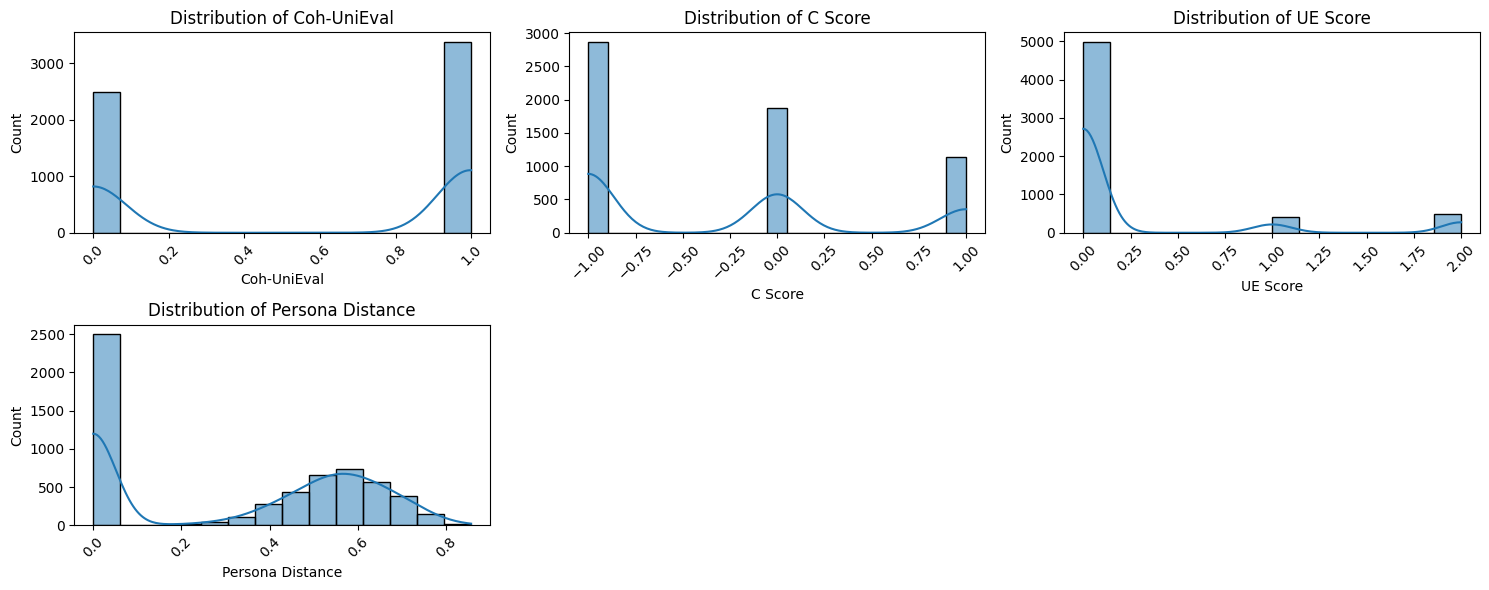

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_analyze = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

plt.figure(figsize=(15, 5*len(columns_to_analyze)//3))
for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(len(columns_to_analyze)//3 + 1, 3, i)
    sns.histplot(data= df, x=column, kde=True)  # kde=True adds a density curve
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
# First get unique context-persona pairs
total_unique_pairs = df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(total_unique_pairs)}")

total_unique_pairs.head(100)

Total unique context-persona pairs: 1946


,personas,context
0,I love nice hotels. I would like to go to Cali...,User1: I think Ive been there before but I don...
1,I am willing to start a seminary in New Brunsw...,User1: I think Ive been there before but I don...
2,I like the National War Memorial. I hope to mo...,"User1: I know this place, but I dont remember ..."
3,I want to visit Indiana. I like pretty cottage...,User1: I think Ive been there before but I don...
4,I find forts interestingI live in the United S...,"User1: I know this place, but I dont remember ..."
...,...,...
95,I like to railway station. I wish to go to Kin...,"User1: I know this place, but I dont remember ..."
96,I like boats. I have an interest for historic ...,User1: I think Ive been there before but I don...
97,I wish to start a Sky Jump in Tampa. I like In...,"User1: Wow, this is amazing! What is this?\nUs..."
98,I like nature. I have not been to Nepal. I am ...,"User1: Wow, this is amazing! What is this?\nUs..."


In [16]:
# Step 1: Filter rows with complete required fields
df_filtered = df[
    df["Coh-UniEval"].notna() &
    df["C Score"].notna() &
    df["UE Score"].notna() &
    df["Persona Distance"].notna() 
].copy()

print(f"Final rows: {len(df_filtered)}")
df_filtered.head()


Final rows: 5888


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
0,I love nice hotels. I would like to go to Cali...,User1: I think Ive been there before but I don...,"Its current owner is Anbang Insurance Group, b...","If you love nice hotels, the Westin St. Franci...",4.351967,0.997592,0,2,0.578833
1,I am willing to start a seminary in New Brunsw...,User1: I think Ive been there before but I don...,It was closely connected with Rutgers Universi...,"The New Brunswick Theological Seminary, which ...",4.427548,0.998938,1,2,0.804227
2,I like the National War Memorial. I hope to mo...,"User1: I know this place, but I dont remember ...",You have interest in history and will like to ...,Although the National War Memorial in Adelaide...,4.363581,0.996822,1,0,0.622529
3,I want to visit Indiana. I like pretty cottage...,User1: I think Ive been there before but I don...,Cottage Home Historic District was built from ...,"Cottage Home Historic District, a charming nei...",4.414613,0.998882,1,0,0.528174
4,I find forts interestingI live in the United S...,"User1: I know this place, but I dont remember ...","No, all defenses except about half of the orig...","As a history enthusiast, I'm intrigued by the ...",4.187770,0.997579,1,0,0.630602


In [17]:
df_filtered.isna().sum()

personas            0
context             0
act_response        0
gen_response        0
response_time       0
Coh-UniEval         0
C Score             0
UE Score            0
Persona Distance    0
dtype: int64

In [18]:
# SCORING_METHOD = "AVG"
SCORING_METHOD = "Length Prioritization"

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Step 2: Normalize metrics to [0, 1]
metrics = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

scaler = MinMaxScaler()
df_filtered[metrics] = scaler.fit_transform(df_filtered[metrics])

# Compute response length in number of words
df_filtered["response"] = df_filtered["gen_response"]
df_filtered["response_length"] = df_filtered["response"].str.split().str.len()

# Set your preferred maximum response length
MAX_LEN = 120

# Compute length penalty (shorter is better)
df_filtered["length_penalty"] = 1.0 - (df_filtered["response_length"] / MAX_LEN)
df_filtered["length_penalty"] = df_filtered["length_penalty"].clip(lower=0.0, upper=1.0)


if SCORING_METHOD == "AVG":
    
    # AVG Style
    df_filtered["quality_score"] = df_filtered[metrics].mean(axis=1)
else:
    
    # Prioritizing the Response Length
    df_filtered["quality_score"] = (
        0.15 * df_filtered["Coh-UniEval"] +
        0.15 * df_filtered["C Score"] +
        0.15 * df_filtered["UE Score"] +
        0.15 * df_filtered["Persona Distance"] + 
        0.4 * df_filtered["length_penalty"]
    )

print("✅ Added normalized quality score:")
df_filtered[["Coh-UniEval", "C Score", "UE Score", "length_penalty", "quality_score"]].head()

✅ Added normalized quality score:


,Coh-UniEval,C Score,UE Score,length_penalty,quality_score
0,0.997732,0.5,1.0,0.458333,0.659290
1,0.999077,1.0,1.0,0.450000,0.770603
2,0.996961,1.0,0.0,0.408333,0.571821
3,0.999022,1.0,0.0,0.450000,0.572285
4,0.997719,1.0,0.0,0.433333,0.583348


In [20]:
print(df_filtered['quality_score'].describe())

count    5888.000000
mean        0.394832
std         0.220019
min         0.083333
25%         0.156667
50%         0.481223
75%         0.583596
max         0.873627
Name: quality_score, dtype: float64


In [21]:
# Step 4: Prepare prompt and extract unique pairs
df_filtered["response"] = df_filtered["gen_response"]
df_filtered["prompt"] = df_filtered.apply(lambda row: f"Persona: {row['personas']}\nContext: {row['context']}", axis=1)

# Get unique (personas, context) pairs
unique_pairs = df_filtered[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(unique_pairs)}")

unique_pairs.head()


Total unique context-persona pairs: 1946


,personas,context
0,I love nice hotels. I would like to go to Cali...,User1: I think Ive been there before but I don...
1,I am willing to start a seminary in New Brunsw...,User1: I think Ive been there before but I don...
2,I like the National War Memorial. I hope to mo...,"User1: I know this place, but I dont remember ..."
3,I want to visit Indiana. I like pretty cottage...,User1: I think Ive been there before but I don...
4,I find forts interestingI live in the United S...,"User1: I know this place, but I dont remember ..."


In [22]:
# Step 5: Build DPO dataset with score-chosen and score-rejected
dpo_records = []

for _, pair in unique_pairs.iterrows():
    sub_df = df_filtered[
        (df_filtered["personas"] == pair["personas"]) &
        (df_filtered["context"] == pair["context"])
    ].sort_values("quality_score", ascending=False)
    
    if len(sub_df) >= 2:
        chosen_row = sub_df.iloc[0]
        rejected_row = sub_df.iloc[-1]
        
        dpo_records.append({
            "prompt": chosen_row["prompt"],
            "chosen": chosen_row["response"],
            "rejected": rejected_row["response"],
            "score_chosen": round(chosen_row["quality_score"], 4),
            "score_rejected": round(rejected_row["quality_score"], 4)
        })

print(f"Total DPO records prepared: {len(dpo_records)}")

Total DPO records prepared: 1865


In [23]:
# Step 6: Final DataFrame
import pandas as pd

dpo_weighted_df = pd.DataFrame(dpo_records)

print(f"Final weighted DPO dataset shape: {dpo_weighted_df.shape}")

# Save weighted DPO dataset to CSV

if SCORING_METHOD == "AVG":
    output_path = "dpo_avg.csv"
else:
    output_path = "dpo_length_prior.csv"  

dpo_weighted_df.to_csv(f"dpo_datasets/{Dataset}_{output_path}", index=False)

print(f" File saved to: {output_path}")

dpo_weighted_df.head(30)

Final weighted DPO dataset shape: (1865, 5)
 File saved to: dpo_length_prior.csv


,prompt,chosen,rejected,score_chosen,score_rejected
0,Persona: I love nice hotels. I would like to g...,"If you love nice hotels, the Westin St. Franci...",I would love to stay at the Westin St. Francis...,0.6593,0.4951
1,Persona: I am willing to start a seminary in N...,"The New Brunswick Theological Seminary, which ...",Before its establishment as an independent ent...,0.7706,0.4654
2,Persona: I like the National War Memorial. I h...,"The National War Memorial in Adelaide, dedicat...",The National War Memorial is dedicated to the ...,0.7114,0.5435
3,Persona: I want to visit Indiana. I like prett...,Cottage Home Historic District was primarily d...,"Cottage Home Historic District, a charming nei...",0.7103,0.5723
4,Persona: I find forts interestingI live in the...,"Yes, Fort Hamilton does retain some of its def...","Yes, Fort Hamilton has maintained many of its ...",0.7888,0.5776
5,Persona: I dont like to live in a building. I ...,The Paddington Town Hall is located in New Sou...,"It's in New South Wales, a state known for its...",0.8641,0.6668
6,Persona: I have seen baseball. I am planning t...,The new Yankee Stadium was designed by the arc...,The new Yankee Stadium was designed by Populou...,0.7555,0.5129
7,Persona: I will travel through North Ayrshire....,"Eglinton Castle, located in North Ayrshire, Sc...",Eglinton Castle has a fascinating history beyo...,0.6600,0.4721
8,Persona: I love Andrew Lloyd Webber. I am a fa...,"The Theatre Royal in Covent Garden, London has...",The Theatre Royal has been designated as a Gra...,0.7523,0.4552
9,Persona: I like to cycling up hills. I love th...,Absolutely! Bidston Hill is open to the public...,"Yes, Bidston Hill is open to the public, and i...",0.6824,0.5076
